In [76]:
# I wanted to inform you that due to hardware limitations, I was unable to run the complete code on the full dataset. 
# As a result, I had to use a smaller subset of images for this evaluation. 
# I apologize for any inconvenience this may cause.

# import libraries 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import StratifiedKFold  # Ensure this import is included
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Hyperparameter tuning library
import keras_tuner as kt
print("Imported all required libraries.")

Imported all required libraries.


In [44]:
# API's
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense

In [45]:
# objective: This project aim is to identity whether it is "Defect" or "Good tyre"

In [46]:
BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224
K_FOLDS = 5

print("Configured global variables:")
print(f"BATCH_SIZE = {BATCH_SIZE}, IMG_HEIGHT = {IMG_HEIGHT}, IMG_WIDTH = {IMG_WIDTH}, K_FOLDS = {K_FOLDS}")

Configured global variables:
BATCH_SIZE = 8, IMG_HEIGHT = 224, IMG_WIDTH = 224, K_FOLDS = 5


In [47]:
# Replace 'data' with the path to your dataset directory
dataset_path = 'data'

dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)
print("Dataset loaded successfully.")

Found 40 files belonging to 2 classes.
Dataset loaded successfully.


In [49]:
# importing - visualize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
print("Importing other libraries and tools")

Importing other libraries and tools


In [50]:
# convert - images and labels
def get_imagesandlabels(dataset):
    print("Imported these libraries")
    images = []
    labels = []
    for image, label in dataset.unbatch():
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

In [51]:
images, labels = get_imagesandlabels(dataset)
print("Images:", images)
print("Labels:", labels)

Imported these libraries
Images: [[[[ 75.78961    78.78961    71.78961  ]
   [ 71.716805   74.716805   67.716805 ]
   [104.41498   107.41498   100.41498  ]
   ...
   [182.23785   183.23785   178.23785  ]
   [180.13306   181.05132   176.29652  ]
   [187.29245   188.1027    183.6719   ]]

  [[ 86.02391    89.02391    82.02391  ]
   [ 68.273254   71.273254   64.27326  ]
   [ 83.238235   86.238235   79.238235 ]
   ...
   [184.20277   185.17357   180.26122  ]
   [178.29237   178.5376    175.80194  ]
   [185.45178   185.45178   183.45178  ]]

  [[ 90.36526    93.36526    86.36526  ]
   [ 74.98357    77.98357    70.98357  ]
   [ 69.57653    72.57653    65.57653  ]
   ...
   [186.48668   186.53539   184.38927  ]
   [178.94156   178.94156   176.94156  ]
   [180.82854   180.82854   178.82854  ]]

  ...

  [[153.6816    155.6816    154.30214  ]
   [151.05191   153.05191   148.97197  ]
   [148.6515    150.6515    145.75417  ]
   ...
   [179.45618   180.45618   185.35616  ]
   [165.97404   166.9740

In [54]:
# EDA Concept
def explore(dataset, dataset_name):
    print(f"\n--- Exploring {dataset_name} Dataset ---")
    
    # class counts
    counts = Counter([label.numpy() for _, label in dataset.unbatch()])
    for cls, count in counts.items():
        if cls == 0: 
            name = "Defective" 
        else:
            name = "Good"

        print(f"Class {cls} ({name}): {count} samples")

    # class distribution
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")
    plt.title(f"{dataset_name} Dataset Class Distribution")

    plt.xlabel("Class")
    plt.ylabel("Counts")
    plt.xticks([0, 1], ['Defective', 'Good'])
    plt.show()
    
    # Display sample
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        number_images = min(len(images), 9)

        for i in range(number_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            class_name = 'Defective' if labels[i] == 0 else 'Good'
            plt.title(f"Class: {class_name}")
            plt.axis("off")
    plt.suptitle(f"Sample Images {dataset_name}", fontsize=8)
    plt.show()


--- Exploring Complete Dataset ---
Class 0 (Defective): 20 samples
Class 1 (Good): 20 samples


C:\Users\sripa\AppData\Local\Temp\ipykernel_13564\781852906.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")


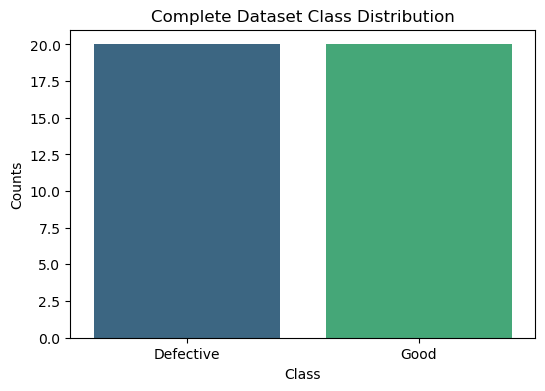

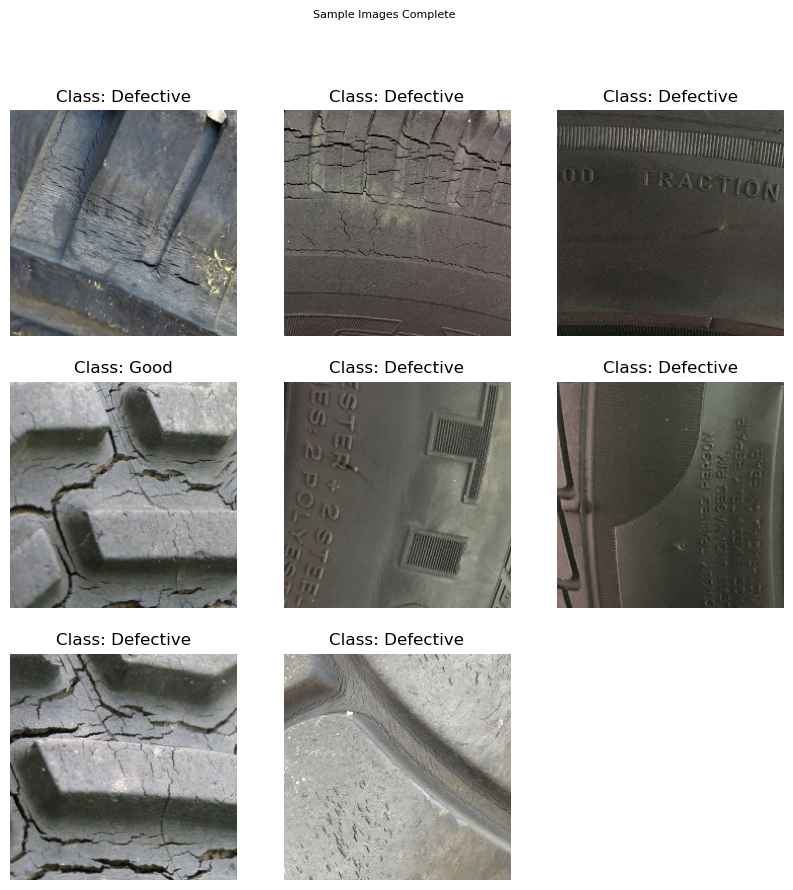

In [55]:
explore(dataset, "Complete")

In [56]:
# Define Data Augmentation transformations # augmentation & normalization

augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1)
])
print("Data augmentation transformations defined")

Data augmentation transformations defined


In [57]:
# Preprocessing the image:

def preprocess_image(image, label):
    image = augmentation(image)
    image = Rescaling(1./255)(image)
    return image, label
dataset = dataset.map(preprocess_image)


print("Preprocessing complete.")

Preprocessing complete.


In [58]:
# Performance improvement

AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Performance optimization complete.")

Performance optimization complete.


In [59]:
# Hyperparameter tuning model to find the accuracy:

def model_builder(hp):
    base_model = VGG16(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    print("Model compiled")
    
    return model

In [60]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='tuner_dir',
                     project_name='product_classifier_tuning')

Reloading Tuner from tuner_dir\product_classifier_tuning\tuner0.json


In [61]:
# Extracting images and labels
def get_images_and_labels(dataset):
    images = []
    labels = []
    for image, label in dataset.unbatch():
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

In [62]:
images, labels = get_images_and_labels(dataset)

In [67]:
np.save('images.npy', images)
np.save('labels.npy', labels)

In [68]:
# cross-validation with hyperparameter tuning

import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define constants
K_FOLDS = 5
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Function to preprocess images
def preprocess_image(image, label):
    # Your preprocessing code here
    return image, label

# Load your data
images = np.load('images.npy')
labels = np.load('labels.npy')

# Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True)
fold_number = 1
accuracies, precisions, recalls, f1s = [], [], [], []

for train_index, val_index in kf.split(images, labels):
    print(f"--- Fold {fold_number} ---")
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(BATCH_SIZE)
    val_data = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(BATCH_SIZE)

    train_data = train_data.map(preprocess_image).cache().prefetch(buffer_size=AUTOTUNE)
    val_data = val_data.map(preprocess_image).cache().prefetch(buffer_size=AUTOTUNE)

    tuner.search(train_data, validation_data=val_data, epochs=10)
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Build, compile, and train the model
    model = tuner.hypermodel.build(best_hps)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data, validation_data=val_data, epochs=10)

    model.save_weights(f'defectandgoodtyre_classifier_fold_{fold_number}.weights.h5')
    model.save(f'defectandgoodtyre_classifier_fold_{fold_number}.h5')

    # Evaluate
    value_predictions = np.argmax(model.predict(val_data), axis=-1)
    value_true = np.concatenate([y for x, y in val_data], axis=0)

    accuracies.append(accuracy_score(value_true, value_predictions))
    precisions.append(precision_score(value_true, value_predictions))
    recalls.append(recall_score(value_true, value_predictions))
    f1s.append(f1_score(value_true, value_predictions))

    fold_number += 1
    tf.keras.backend.clear_session()


--- Fold 1 ---
Model compiled
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.5938 - loss: 0.7776 - val_accuracy: 0.1250 - val_loss: 1.4618
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.6562 - loss: 0.9047 - val_accuracy: 0.5000 - val_loss: 3.1915
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.7188 - loss: 1.1018 - val_accuracy: 0.5000 - val_loss: 8.2532
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.5000 - loss: 4.1818 - val_accuracy: 0.5000 - val_loss: 3.8827
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.7812 - loss: 0.5102 - val_accuracy: 0.3750 - val_loss: 4.2095
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.7500 - loss: 0.8457 - val_accuracy: 0.2500 - val_loss: 4.4346
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.8438 - loss: 0.9175 - val_accuracy: 0.2500 - val_loss: 3.8345
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.7500 - loss: 0.9801 - val_accuracy: 0.12

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
--- Fold 2 ---
Model compiled
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.4375 - loss: 0.9385 - val_accuracy: 0.5000 - val_loss: 11.5341
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.5000 - loss: 10.7001 - val_accuracy: 0.5000 - val_loss: 1.2049
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.5938 - loss: 1.1413 - val_accuracy: 0.5000 - val_loss: 6.9234
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.5000 - loss: 6.7066 - val_accuracy: 0.5000 - val_loss: 6.1730
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.5000 - loss: 5.2767 - val_accuracy: 0.5000 - val_loss: 2.8029
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.5625 - loss: 1.6565 - val_accuracy: 0.5000 - val_loss: 1.7865
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.6562 - loss: 1.0764 - val_accuracy: 0.5000 - val_loss: 3.9638
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
--- Fold 3 ---
Model compiled
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.6875 - loss: 0.6645 - val_accuracy: 0.5000 - val_loss: 2.6014
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.5625 - loss: 1.8455 - val_accuracy: 0.5000 - val_loss: 13.3865
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.5000 - loss: 12.1277 - val_accuracy: 0.5000 - val_loss: 9.8990
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5000 - loss: 7.3806 - val_accuracy: 0.1250 - val_loss: 2.4448
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6875 - loss: 0.8492 - val_accuracy: 0.5000 - val_loss: 8.2307
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5938 - loss: 3.1768 - val_accuracy: 0.5000 - val_loss: 8.3195
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5938 - loss: 4.0300 - val_accuracy: 0.3750 - val_loss: 4.4746
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.7812 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
--- Fold 4 ---
Model compiled
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.5000 - loss: 0.8743 - val_accuracy: 0.5000 - val_loss: 11.2794
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.5000 - loss: 10.4716 - val_accuracy: 0.5000 - val_loss: 1.3733
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5312 - loss: 1.1580 - val_accuracy: 0.5000 - val_loss: 5.5640
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5000 - loss: 5.4192 - val_accuracy: 0.5000 - val_loss: 5.6705
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5000 - loss: 5.1301 - val_accuracy: 0.5000 - val_loss: 4.2638
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5000 - loss: 4.0213 - val_accuracy: 0.5000 - val_loss: 1.8455
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5938 - loss: 1.2964 - val_accuracy: 0.5000 - val_loss: 1.2388
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5938 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
--- Fold 5 ---
Model compiled
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.5000 - loss: 1.1331 - val_accuracy: 0.5000 - val_loss: 12.5781
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.5000 - loss: 12.0508 - val_accuracy: 0.5000 - val_loss: 5.7074
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.5000 - loss: 4.7210 - val_accuracy: 0.5000 - val_loss: 2.9651
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5312 - loss: 2.1142 - val_accuracy: 0.5000 - val_loss: 4.3519
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5000 - loss: 3.6948 - val_accuracy: 0.5000 - val_loss: 3.1542
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5312 - loss: 2.2474 - val_accuracy: 0.3750 - val_loss: 0.9478
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.6250 - loss: 0.9411 - val_accuracy: 0.5000 - val_loss: 2.4542
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.6250 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [69]:
# Calculate average metrics
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1 = np.mean(f1s)

In [72]:
# Business impact analysis
def businessreport():
    print("\nBusiness Impact Report")
    print(f"Final Test Accuracy: {average_accuracy:.2f}")
    print(f"Final Precision: {average_precision:.2f}")
    print(f"Final Recall: {average_recall:.2f}")
    print(f"Reduction in defective products by {average_accuracy * 100:.2f}%.")
    print(f"Average Accuracy: {np.mean(accuracies)}")
    print(f"Average Precision: {np.mean(precisions)}")
    print(f"Average Recall: {np.mean(recalls)}")
    print(f"Average F1 Score: {np.mean(f1s)}")

In [73]:
# Generate the report
businessreport()


Business Impact Report
Final Test Accuracy: 0.40
Final Precision: 0.41
Final Recall: 0.70
Reduction in defective products by 40.00%.
Average Accuracy: 0.4
Average Precision: 0.4066666666666666
Average Recall: 0.7
Average F1 Score: 0.5015873015873015


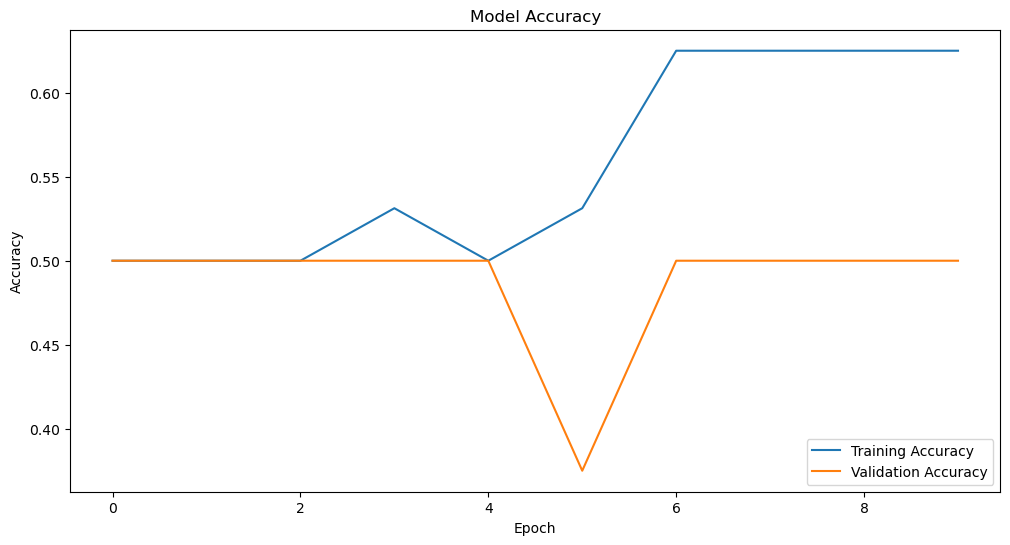

In [74]:
# Visualize training and validation performance
def training(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()
training(history)